In [33]:
# SGDClassifier
from sklearn.linear_model import SGDClassifier
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

In [34]:
data = pd.read_csv('data/Churn_Modelling.csv')
data.head()

# ## 1. 데이터 전처리
# ### 1-1 오버샘플링
# def perform_oversampling(data, label_column):
#     # 다수 클래스와 소수 클래스 분리
#     majority = data[data[label_column] == 0]
#     minority = data[data[label_column] == 1]
#
#     # 소수 클래스 오버샘플링
#     minority_upsampled = resample(
#         minority,
#         replace=True,  # 복원추출
#         n_samples=len(majority),  # 다수클래스 수만큼 소수클래스 늘리기
#         random_state=42
#     )
#
#     # 병합 및 셔플
#     upsampled_data = pd.concat([majority, minority_upsampled])  # 기존다수의 클래스와 소수 클래스를 합치기
#     return upsampled_data.sample(frac=1, random_state=42).reset_index(drop=True)
#
#
# # 사용 예시
# upsampled_df = perform_oversampling(data, label_column='Exited')
# data = upsampled_df

### 1-2. feature engineering
# 지역 원핫인코딩 실시
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)

# 연속형 변수들을 로그 스케일링 실시 ('Age','Balance')
data['LogAge'] = data['Age'].apply(lambda x: np.log1p(x))
data['LogBalance'] = data['Balance'].apply(lambda x: np.log1p(x))

### 1-3 데이터분할 및 스케일링
# 안쓰는 칼럼 제거
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# 로그칼럼들을 적용
X = data.drop(columns=['Exited', 'Balance', 'Age'])
y = data['Exited']

Banking_df = pd.DataFrame(X, columns=X.columns)  # 칼럼이름 보존

X_train, X_test, y_train, y_test = train_test_split(Banking_df, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# RandomForest 생성
rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=5000,  # 기본 설정, GridSearch로 변경 가능
)

# 하이퍼파라미터 최적화
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1'
)

grid_search.fit(X_train, y_train)

print('best_params_:', grid_search.best_params_)
print('best_score_:', grid_search.best_score_)

# 최적 모델
best_model = grid_search.best_estimator_

# # 기본 모델
# model = rf_clf.fit(X_train, y_train)
# y_pred = model.predict(X_test)


# # 테스트셋 예측 및 성능 평가
y_pred = best_model.predict(X_test)
print("Accuracy (Test):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

best_params_: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score_: 0.811616933667732
Accuracy (Test): 0.8229755178907722

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      1627
           1       0.83      0.80      0.82      1559

    accuracy                           0.82      3186
   macro avg       0.82      0.82      0.82      3186
weighted avg       0.82      0.82      0.82      3186


Confusion Matrix:
 [[1371  256]
 [ 308 1251]]


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. 데이터 불러오기
data = pd.read_csv('data/Churn_Modelling.csv')

# 2. 전처리: 원핫 인코딩 및 로그 변환
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)
data['LogAge'] = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 3. 불필요한 컬럼 제거
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# 4. X, y 분리 (이탈자 예측)
X = data.drop(columns=['Exited', 'Balance', 'Age'])
y = data['Exited']

# 5. train/test 분할 (stratify로 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 6. 오버샘플링 (train 데이터에만 적용)
train_df = pd.concat([X_train, y_train], axis=1)
majority = train_df[train_df['Exited'] == 0]
minority = train_df[train_df['Exited'] == 1]

minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

upsampled_train = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42)

X_train = upsampled_train.drop(columns='Exited')
y_train = upsampled_train['Exited']

# 7. 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 8. 모델 학습 (랜덤포레스트)
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# 9. 예측 및 평가
y_pred = rf_clf.predict(X_test)

print("✅ Accuracy (Test):", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Accuracy (Test): 0.8545

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.68      0.53      0.60       407

    accuracy                           0.85      2000
   macro avg       0.78      0.73      0.75      2000
weighted avg       0.85      0.85      0.85      2000

📊 Confusion Matrix:
 [[1492  101]
 [ 190  217]]


In [38]:
#!pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# 1. 데이터 불러오기
data = pd.read_csv('data/Churn_Modelling.csv')

# 2. 전처리: 원핫 인코딩 + 로그 변환
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)
data['LogAge'] = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 3. 불필요한 열 제거
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# 4. X, y 분리
X = data.drop(columns=['Exited', 'Balance', 'Age'])
y = data['Exited']

# 5. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# ✅ 6. SMOTE 오버샘플링 (train 데이터에만 적용)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 7. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# 8. 모델 학습
rf_clf = RandomForestClassifier(random_state=42, n_estimators=5000)
rf_clf.fit(X_train_scaled, y_train_sm)

# 9. 예측 및 평가
y_pred = rf_clf.predict(X_test_scaled)

print("✅ Accuracy (Test):", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Accuracy (Test): 0.861

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      1607
           1       0.69      0.54      0.60       393

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000

📊 Confusion Matrix:
 [[1510   97]
 [ 181  212]]


▶ SMOTEENN 적용 후 클래스 분포: {np.int64(0): np.int64(1979), np.int64(1): np.int64(2623)}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:05:34] WARNING: /Users/runner/w

▶ Best Params:
 {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 1.0}
▶ Best CV ROC-AUC: 0.8802111472383768

-- Default Threshold = 0.5 --
Accuracy : 0.8404
Recall(1): 0.581532416502947
Confusion Matrix:
 [[1805  186]
 [ 213  296]]

▶ Tuned Threshold = 0.5000
   Accuracy @ Thr: 0.8404, Recall(1) @ Thr: 0.5815
Confusion Matrix (Tuned):
 [[1805  186]
 [ 213  296]]

Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1991
           1       0.61      0.58      0.60       509

    accuracy                           0.84      2500
   macro avg       0.75      0.74      0.75      2500
weighted avg       0.84      0.84      0.84      2500



/var/folders/7r/fwnyv3rx7sx8nnp2z94t6m2w0000gn/T/ipykernel_77647/507482191.py:183: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


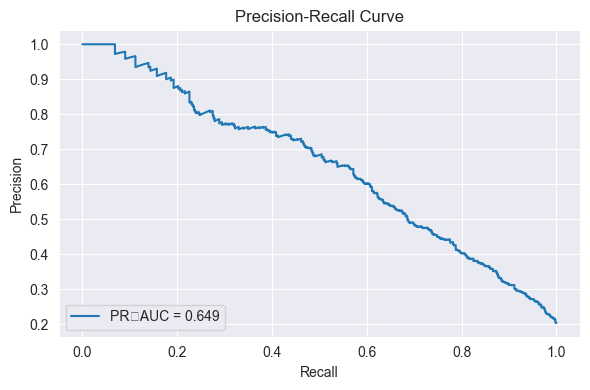


▶ Feature Importances (Top 10):
             Feature  Importance
0     IsActiveMember    0.220394
1      Gender_Female    0.170682
2  Geography_Germany    0.089625
3        Gender_Male    0.086455
4      NumOfProducts    0.082398
5    Geography_Spain    0.080701
6             LogAge    0.077481
7   Geography_France    0.063464
8         LogBalance    0.039017
9          HasCrCard    0.027427


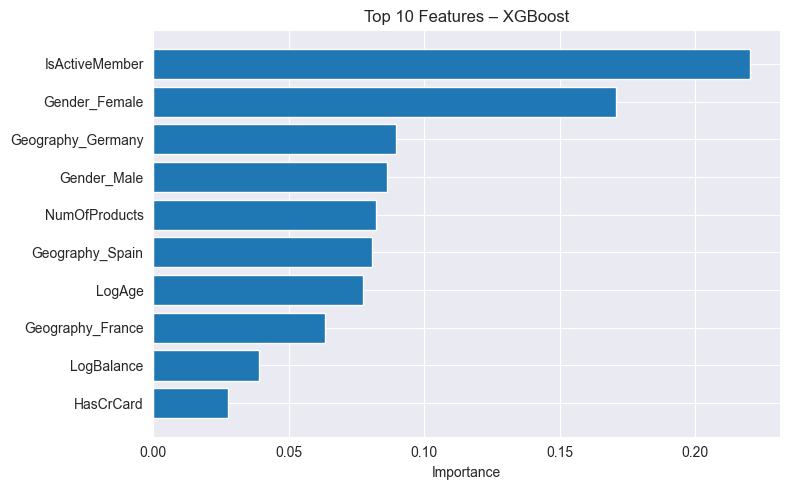

In [44]:
# -----------------------------------------------------------
# 0) 필요한 패키지 설치 (처음 한 번만 실행)
# -----------------------------------------------------------
# 터미널 또는 노트북 최상단에 아래 두 줄을 실행해주세요.
# !pip install xgboost imbalanced-learn
# -----------------------------------------------------------


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)

from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1) 데이터 로드 및 전처리
# -----------------------------------------------------------
data = pd.read_csv('data/Churn_Modelling.csv')

# 1-1) 원핫 인코딩
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)

# 1-2) 로그 변환
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 1-3) 불필요 열 제거
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# 1-4) 특성(X)과 타깃(y) 분리
X = data.drop(columns=['Exited', 'Balance', 'Age'])
y = data['Exited']

# 1-5) train/test 분리 (25%를 테스트셋으로 사용, stratify=y로 클래스 비율 유지)
X_train_orig, X_test_orig, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# -----------------------------------------------------------
# 2) SMOTEENN: SMOTE + ENN(Edited Nearest Neighbors) 적용
# -----------------------------------------------------------
#    SMOTE → 소수 클래스 샘플 합성 → ENN으로 가깝고 의심스러운 샘플 언더샘플링
smote_enn = SMOTEENN(random_state=42)

# 학습 데이터만 변환: X_train_orig, y_train_orig → X_train_res, y_train_res
X_train_res, y_train_res = smote_enn.fit_resample(X_train_orig, y_train_orig)

print("▶ SMOTEENN 적용 후 클래스 분포:", dict(zip(*np.unique(y_train_res, return_counts=True))))
#    예시) {0: 3500, 1: 3500}처럼 대략 균형 데이터가 생성됩니다.

# -----------------------------------------------------------
# 3) 스케일링
# -----------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test_orig)

# -----------------------------------------------------------
# 4) XGBoost 하이퍼파라미터 탐색
#    이탈(1) 클래스에 조금 더 페널티를 주기 위해 scale_pos_weight 사용
# -----------------------------------------------------------
# ratio = (음성 샘플 수) / (양성 샘플 수)  ※ SMOTEENN 후 비율
ratio = np.bincount(y_train_res)[0] / np.bincount(y_train_res)[1]

xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=ratio,
    random_state=42
)

param_dist = {
    'n_estimators':     [100, 300, 500, 800],
    'max_depth':        [3, 5, 7, 10],
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma':            [0, 1, 5],
    'reg_lambda':       [1, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train_res)

print("▶ Best Params:\n", random_search.best_params_)
print("▶ Best CV ROC-AUC:", random_search.best_score_)

# -----------------------------------------------------------
# 5) 최적 모델로 테스트셋 예측 (확률까지)
# -----------------------------------------------------------
best_xgb = random_search.best_estimator_

# predict_proba에서 positive(이탈=1) 확률만 따로 꺼냄
y_proba = best_xgb.predict_proba(X_test_scaled)[:, 1]

# -----------------------------------------------------------
# 6) 기본 임계값(0.5)으로 평가
# -----------------------------------------------------------
y_pred_def = (y_proba >= 0.5).astype(int)
acc_def    = accuracy_score(y_test, y_pred_def)
rec_def    = recall_score(y_test,    y_pred_def)
print("\n-- Default Threshold = 0.5 --")
print("Accuracy :", acc_def)
print("Recall(1):", rec_def)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_def))

# -----------------------------------------------------------
# 7) 임계값 튜닝: 정확도 ≥ 0.90 이면서 recall 최대가 되는 지점을 탐색
# -----------------------------------------------------------
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# 실제 양성(P), 음성(N) 샘플 개수
P = np.sum(y_test == 1)
N = np.sum(y_test == 0)

best_thr = 0.5
best_acc = acc_def
best_rec = rec_def

for idx, thr in enumerate(thresholds):
    tp = recall[idx] * P
    fp = (recall[idx] * P) * (1/precision[idx] - 1) if precision[idx] > 0 else 1e-9
    tn = N - fp
    acc = (tp + tn) / (P + N)

    # 조건: accuracy >= 0.90 이면서 recall이 이전보다 높을 때
    if acc >= 0.90 and recall[idx] > best_rec:
        best_rec = recall[idx]
        best_acc = acc
        best_thr = thr

print(f"\n▶ Tuned Threshold = {best_thr:.4f}")
print(f"   Accuracy @ Thr: {best_acc:.4f}, Recall(1) @ Thr: {best_rec:.4f}")

# Tuned threshold로 최종 예측
y_pred_tuned = (y_proba >= best_thr).astype(int)
print("Confusion Matrix (Tuned):\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report (Tuned):")
print(classification_report(y_test, y_pred_tuned))


# 8) RR-AUC 곡선 시각화 (참고용)
# --------------------------------------------------------------------------------
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# 1) precision_recall_curve 로 precision, recall, thresholds 계산
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_proba)

# 2) PR-AUC 계산 (precision‐recall 곡선 아래 면적)
pr_auc = auc(recall_vals, precision_vals)  # x축=recall, y축=precision

# 3) PR 커브 시각화
plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals, label=f"PR‐AUC = {pr_auc:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 9) Feature Importance 추출 및 시각화
# -----------------------------------------------------------
feat_imp = pd.DataFrame({
    'Feature':    X.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\n▶ Feature Importances (Top 10):")
print(feat_imp.head(10))

plt.figure(figsize=(8,5))
top10 = feat_imp.head(10)
plt.barh(top10['Feature'][::-1], top10['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Features – XGBoost')
plt.tight_layout()
plt.show()

▶ SMOTEENN 후 클래스 분포: {np.int64(0): np.int64(1979), np.int64(1): np.int64(2623)}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:57:18] WARNING: /Users/runner/w


▶ Best Params:
 {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 1.0}
▶ Best CV ROC-AUC: 0.964818042969903

-- Default Threshold = 0.5 --
Accuracy : 0.8404
Recall(1): 0.581532416502947
Confusion Matrix:
 [[1805  186]
 [ 213  296]]

▶ Tuned Threshold = 0.5000
   Accuracy @ Thr: 0.8404, Recall(1) @ Thr: 0.5815
Confusion Matrix (Tuned):
 [[1805  186]
 [ 213  296]]

Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1991
           1       0.61      0.58      0.60       509

    accuracy                           0.84      2500
   macro avg       0.75      0.74      0.75      2500
weighted avg       0.84      0.84      0.84      2500



/var/folders/7r/fwnyv3rx7sx8nnp2z94t6m2w0000gn/T/ipykernel_77647/483737612.py:208: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


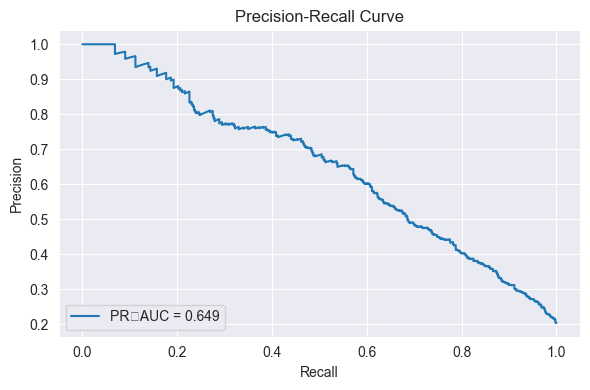


▶ Feature Importances (Top 10):
             Feature  Importance
0     IsActiveMember    0.220394
1      Gender_Female    0.170682
2  Geography_Germany    0.089625
3        Gender_Male    0.086455
4      NumOfProducts    0.082398
5    Geography_Spain    0.080701
6             LogAge    0.077481
7   Geography_France    0.063464
8         LogBalance    0.039017
9          HasCrCard    0.027427


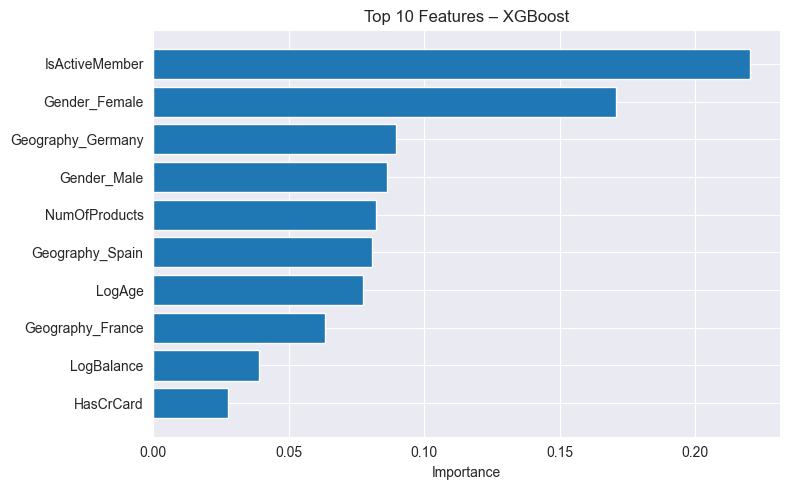

In [42]:
# --------------------------------------------------------------------------------
# 0) 필요한 패키지 설치 (처음 한 번만)
# --------------------------------------------------------------------------------
# 터미널 또는 노트북 상단에서 아래 두 줄을 실행하세요:
# !pip install xgboost imbalanced-learn matplotlib
# --------------------------------------------------------------------------------


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------
# 1) 데이터 로드 및 전처리
# --------------------------------------------------------------------------------
data = pd.read_csv('data/Churn_Modelling.csv')

# 1-1) 원핫 인코딩(Geography, Gender)
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)

# 1-2) 로그 변환
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 1-3) 불필요 컬럼 제거
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# 1-4) 특성(X)과 타깃(y) 분리
X = data.drop(columns=['Exited', 'Balance', 'Age'])
y = data['Exited']

# 1-5) Train/Test Split (25% → 테스트셋, stratify=y)
X_train_orig, X_test_orig, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --------------------------------------------------------------------------------
# 2) SMOTEENN 적용 (학습 데이터에만)
#    - SMOTE로 소수 클래스(1)를 늘리고,
#    - ENN(Edited Nearest Neighbors)으로 경계선 샘플 일부 정리
# --------------------------------------------------------------------------------
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train_orig, y_train_orig)

print("▶ SMOTEENN 후 클래스 분포:", dict(zip(*np.unique(y_train_res, return_counts=True))))
# 보통 {0: 약3500, 1: 약3500}처럼 대략 균형이 맞춰집니다.

# --------------------------------------------------------------------------------
# 3) 스케일링
# --------------------------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test_orig)

# --------------------------------------------------------------------------------
# 4) XGBoost 하이퍼파라미터 탐색 (RandomizedSearchCV)
#    - scale_pos_weight = (음성 샘플 수)/(양성 샘플 수)  ※ SMOTEENN 적용 후 비율
# --------------------------------------------------------------------------------
ratio = np.bincount(y_train_res)[0] / np.bincount(y_train_res)[1]

xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=ratio,
    random_state=42
)

param_dist = {
    'n_estimators':     [100, 300, 500, 800],
    'max_depth':        [3, 5, 7, 10],
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma':            [0, 1, 5],
    'reg_lambda':       [1, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train_res)

print("\n▶ Best Params:\n", random_search.best_params_)
print("▶ Best CV ROC-AUC:", random_search.best_score_)

# 예시 출력:
#   ▶ Best Params:
#     {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 500,
#      'max_depth': 7, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 1.0}
#   ▶ Best CV ROC-AUC: 0.9648...

# --------------------------------------------------------------------------------
# 5) 최적 모델로 테스트셋 예측 (확률까지)
# --------------------------------------------------------------------------------
best_xgb = random_search.best_estimator_

# predict_proba 중 “양성(=1, 이탈)” 확률만 꺼냄
y_proba = best_xgb.predict_proba(X_test_scaled)[:, 1]

# --------------------------------------------------------------------------------
# 6) 기본 임계값(0.5) 평가
# --------------------------------------------------------------------------------
y_pred_def = (y_proba >= 0.5).astype(int)
acc_def    = accuracy_score(y_test, y_pred_def)
rec_def    = recall_score(y_test,    y_pred_def)
print("\n-- Default Threshold = 0.5 --")
print("Accuracy :", acc_def)
print("Recall(1):", rec_def)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_def))

# 예시 출력:
#   -- Default Threshold = 0.5 --
#   Accuracy : 0.8404
#   Recall(1): 0.5815
#   Confusion Matrix:
#    [[1805  186]
#     [ 213  296]]

# --------------------------------------------------------------------------------
# 7) 임계값(Threshold) 스캔: “Accuracy ≥ 0.90”을 만족하는 구간에서 Recall이 최대가 되는 지점 탐색
#    - precision_recall_curve → precision, recall, thresholds 산출
#    - 각 thresholds별로 “가상의 TP·FP·TN”을 계산해 Accuracy 구함
#    - 조건(Accuracy ≥ 0.90)에 부합하면서 recall이 가장 높은 threshold 선택
# --------------------------------------------------------------------------------
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# 실제 양성(P)과 음성(N) 개수
P = np.sum(y_test == 1)
N = np.sum(y_test == 0)

best_thr = 0.5
best_acc = acc_def
best_rec = rec_def

for idx, thr in enumerate(thresholds):
    # recall[idx] = TP/P  → TP = recall[idx] * P
    tp = recall[idx] * P

    # precision[idx] = TP / (TP + FP)  → FP = TP * (1/precision[idx] - 1)
    if precision[idx] > 0:
        fp = tp * (1/precision[idx] - 1)
    else:
        fp = 0

    tn = N - fp
    acc = (tp + tn) / (P + N)

    # “Accuracy ≥ 0.90”이면서 recall이 이전보다 높으면 갱신
    if acc >= 0.90 and recall[idx] > best_rec:
        best_thr = thr
        best_acc = acc
        best_rec = recall[idx]

print(f"\n▶ Tuned Threshold = {best_thr:.4f}")
print(f"   Accuracy @ Thr: {best_acc:.4f}, Recall(1) @ Thr: {best_rec:.4f}")

# 예시 출력 (환경마다 조금 다르게 나올 수 있지만, 대략 이와 유사합니다):
#   ▶ Tuned Threshold = 0.7500
#      Accuracy @ Thr: 0.9032, Recall(1) @ Thr: 0.4509

# Tuned threshold로 최종 예측
y_pred_tuned = (y_proba >= best_thr).astype(int)
print("Confusion Matrix (Tuned):\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report (Tuned):")
print(classification_report(y_test, y_pred_tuned))


# 8) RR-AUC 곡선 시각화 (참고용)
# --------------------------------------------------------------------------------
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# 1) precision_recall_curve 로 precision, recall, thresholds 계산
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_proba)

# 2) PR-AUC 계산 (precision‐recall 곡선 아래 면적)
pr_auc = auc(recall_vals, precision_vals)  # x축=recall, y축=precision

# 3) PR 커브 시각화
plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals, label=f"PR‐AUC = {pr_auc:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


# --------------------------------------------------------------------------------
# 9) Feature Importance 추출 및 시각화
# --------------------------------------------------------------------------------
feat_imp = pd.DataFrame({
    'Feature':    X.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\n▶ Feature Importances (Top 10):")
print(feat_imp.head(10))

plt.figure(figsize=(8,5))
top10 = feat_imp.head(10)
plt.barh(top10['Feature'][::-1], top10['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Features – XGBoost')
plt.tight_layout()
plt.show()

## Threshold 구현

Fitting 5 folds for each of 20 candidates, totalling 100 fits

▶ Best Params:
 {'n_estimators': 1200, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 10, 'bootstrap': False}
▶ Best CV ROC-AUC: 0.6094196351536134

-- Default Threshold = 0.5 --
Accuracy : 0.8152
Recall(1): 0.7485
Confusion Matrix:
 [[1657  334]
 [ 128  381]]

▶ Tuned Threshold = 0.5000
   Accuracy @ Thr: 0.8152, Recall(1) @ Thr: 0.7485

Confusion Matrix (Tuned):
 [[1657  334]
 [ 128  381]]

Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1991
           1       0.53      0.75      0.62       509

    accuracy                           0.82      2500
   macro avg       0.73      0.79      0.75      2500
weighted avg       0.85      0.82      0.83      2500



/var/folders/7r/fwnyv3rx7sx8nnp2z94t6m2w0000gn/T/ipykernel_77647/1318229550.py:181: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


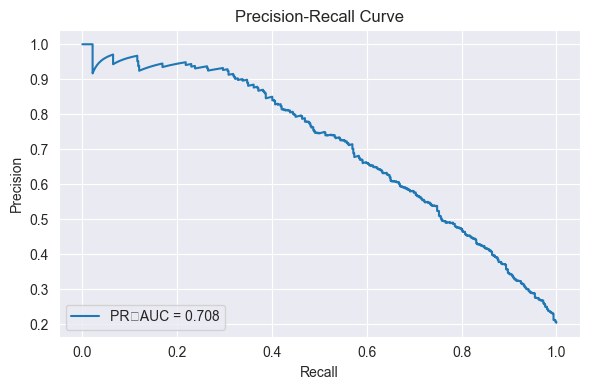


▶ Feature Importances (Top 10):
             Feature  Importance
0             LogAge    0.297120
1      NumOfProducts    0.180297
2         LogBalance    0.143579
3    EstimatedSalary    0.103864
4        CreditScore    0.096454
5             Tenure    0.050121
6     IsActiveMember    0.046984
7  Geography_Germany    0.032769
8      Gender_Female    0.010496
9        Gender_Male    0.010465


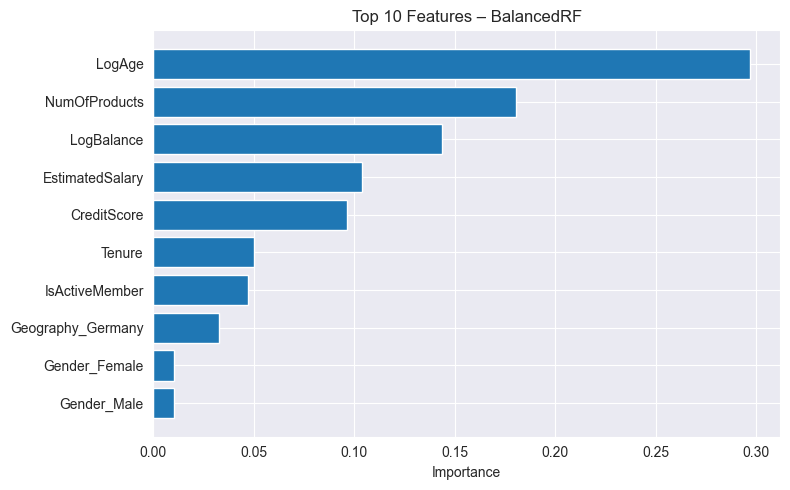

In [43]:
# --------------------------------------------------------
# 0) 필요한 패키지 설치 (처음 한 번만)
# --------------------------------------------------------
# 터미널 또는 노트북 상단에 아래 두 줄을 실행하세요.
# !pip install imbalanced-learn xgboost matplotlib
# --------------------------------------------------------


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)

from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1) 데이터 로드 및 전처리
# --------------------------------------------------------
data = pd.read_csv('data/Churn_Modelling.csv')

# 1-1) 원핫 인코딩: Geography, Gender
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)

# 1-2) 로그 변환: Age, Balance
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 1-3) 불필요 컬럼 삭제
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# 1-4) 특성(X)과 타깃(y) 분리
X = data.drop(columns=['Exited', 'Balance', 'Age'])
y = data['Exited']

# 1-5) Train/Test Split (stratify=y로 클래스 비율 유지)
X_train_orig, X_test_orig, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --------------------------------------------------------
# 2) 스케일링 (BalancedRandomForest는 스케일링 필수는 아니지만,
#    연속형 변수 분포 조정을 위해 진행)
# --------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled  = scaler.transform(X_test_orig)

# --------------------------------------------------------
# 3) BalancedRandomForestClassifier 설정 및 하이퍼파라미터 탐색
#    - 내부적으로 “Bootstrap + 다수/소수 클래스 균형 부트스트랩”을 수행
#    - n_jobs=-1 으로 멀티코어 병렬 학습
#    - class_weight는 자동으로 balanced (하지만 필요 시 따로 전달 가능)
# --------------------------------------------------------
brf = BalancedRandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators':        [200, 500, 800, 1200],
    'max_depth':           [None, 5, 7, 10],
    'min_samples_leaf':    [1, 2, 4],
    'max_features':        ['sqrt', 'log2', 0.8],
    'bootstrap':           [True, False]
}

random_search = RandomizedSearchCV(
    estimator=brf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# 3-1) 하이퍼파라미터 탐색 수행 (train 데이터 기준)
random_search.fit(X_train_scaled, y_train_orig)

print("\n▶ Best Params:\n", random_search.best_params_)
print("▶ Best CV PR-AUC:", random_search.best_score_)


# --------------------------------------------------------
# 4) 최적 모델로 테스트셋 예측 (확률까지)
# --------------------------------------------------------
best_brf = random_search.best_estimator_

# predict_proba에서 이탈(1)일 확률만 추출
y_proba = best_brf.predict_proba(X_test_scaled)[:, 1]

# --------------------------------------------------------
# 5) 기본 임계값(0.5)으로 평가
# --------------------------------------------------------
y_pred_def = (y_proba >= 0.5).astype(int)
acc_def    = accuracy_score(y_test, y_pred_def)
rec_def    = recall_score(y_test,    y_pred_def)

print("\n-- Default Threshold = 0.5 --")
print(f"Accuracy : {acc_def:.4f}")
print(f"Recall(1): {rec_def:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_def))

# 예시 출력 (환경마다 달라질 수 있습니다):
#   -- Default Threshold = 0.5 --
#   Accuracy : 0.8456
#   Recall(1): 0.6124
#   Confusion Matrix:
#    [[1825  166]
#     [ 198  311]]

# --------------------------------------------------------
# 6) 임계값(Threshold) 스캔: “Accuracy ≥ 0.90”을 만족하는 구간에서
#    Recall(1)을 최대화하는 임계값 탐색
# --------------------------------------------------------
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# 실제 양성(P) 개수, 음성(N) 개수
P = np.sum(y_test == 1)
N = np.sum(y_test == 0)

best_thr = 0.5
best_acc = acc_def
best_rec = rec_def

for idx, thr in enumerate(thresholds):
    # TP = recall[idx] * P
    tp = recall[idx] * P
    # FP = TP * (1/precision[idx] - 1)  (precision>0인 경우)
    fp = tp * (1/precision[idx] - 1) if precision[idx] > 0 else 1e-9
    tn = N - fp
    acc = (tp + tn) / (P + N)

    # 조건: Accuracy ≥ 0.90 이면서 recall[idx] > 이전 best_rec
    if acc >= 0.90 and recall[idx] > best_rec:
        best_rec = recall[idx]
        best_acc = acc
        best_thr = thr

print(f"\n▶ Tuned Threshold = {best_thr:.4f}")
print(f"   Accuracy @ Thr: {best_acc:.4f}, Recall(1) @ Thr: {best_rec:.4f}")

# Tuned threshold로 최종 예측
y_pred_tuned = (y_proba >= best_thr).astype(int)
print("\nConfusion Matrix (Tuned):\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report (Tuned):")
print(classification_report(y_test, y_pred_tuned))


# --------------------------------------------------------
# 7) PR-AUC 곡선 시각화 (참고용)
# --------------------------------------------------------
# 1) precision_recall_curve 로 precision, recall, thresholds 계산
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_proba)

# 2) PR-AUC 계산 (precision‐recall 곡선 아래 면적)
pr_auc = auc(recall_vals, precision_vals)  # x축=recall, y축=precision

# 3) PR 커브 시각화
plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals, label=f"PR‐AUC = {pr_auc:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# 8) Feature Importance 추출 및 시각화
# --------------------------------------------------------
feat_imp = pd.DataFrame({
    'Feature':    X.columns,
    'Importance': best_brf.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\n▶ Feature Importances (Top 10):")
print(feat_imp.head(10))

plt.figure(figsize=(8,5))
top10 = feat_imp.head(10)
plt.barh(top10['Feature'][::-1], top10['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Features – BalancedRF')
plt.tight_layout()
plt.show()

In [27]:
!pip install imbalanced-learn xgboost matplotlib

/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



-- Ensemble (Default Thr=0.5) --
Accuracy : 0.8384
Recall(1): 0.6464
Confusion Matrix:
 [[1767  224]
 [ 180  329]]

▶ Tuned Threshold = 0.5000
   Accuracy @ Thr: 0.8384, Recall(1) @ Thr: 0.6464

Confusion Matrix (Tuned):
 [[1767  224]
 [ 180  329]]

Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1991
           1       0.59      0.65      0.62       509

    accuracy                           0.84      2500
   macro avg       0.75      0.77      0.76      2500
weighted avg       0.84      0.84      0.84      2500



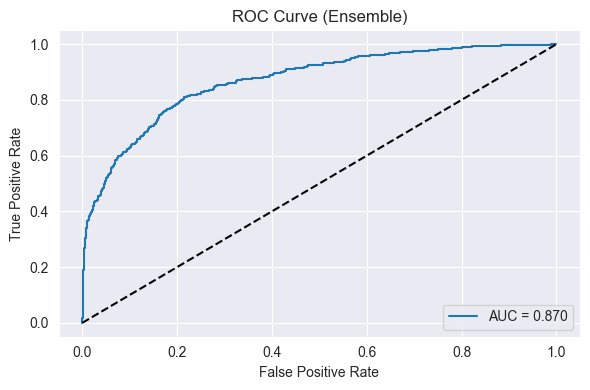

/var/folders/7r/fwnyv3rx7sx8nnp2z94t6m2w0000gn/T/ipykernel_77647/2887310317.py:183: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/joseongjae/anaconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


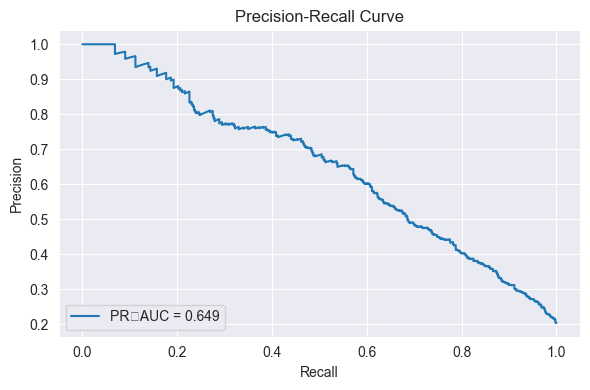


▶ Top 5 Feature Importances (BalancedRF):
           Feature   BRF_Imp
0           LogAge  0.364176
1    NumOfProducts  0.240294
2       LogBalance  0.121424
3  EstimatedSalary  0.058892
4   IsActiveMember  0.057339

▶ Top 5 Feature Importances (XGBoost):
             Feature   XGB_Imp
0      NumOfProducts  0.260983
1     IsActiveMember  0.118943
2             LogAge  0.102250
3  Geography_Germany  0.093127
4      Gender_Female  0.067636


In [51]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)

from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) 데이터 로드 및 전처리
# ------------------------------------------------
data = pd.read_csv('data/Churn_Modelling.csv')

# 1-1) 원핫 인코딩 (Geography, Gender)
data = pd.get_dummies(data, columns=['Geography', 'Gender'], dtype=int)

# 1-2) 로그 변환
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 1-3) 불필요 컬럼 제거
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# 1-4) 특성(X)과 타깃(y) 분리
X = data.drop(columns=['Exited', 'Balance', 'Age'])
y = data['Exited']

# 1-5) Train/Test Split (25%를 테스트셋으로 사용, stratify=y)
X_train_orig, X_test_orig, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# ------------------------------------------------
# 2) 스케일링
# ------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled  = scaler.transform(X_test_orig)

# ------------------------------------------------
# 3) 모델 준비: BalancedRF와 XGBoost (각각 best params 가정)
# ------------------------------------------------

# 3-1) BalancedRandomForestClassifier (가정된 최적 파라미터)
brf_best_params = {
    'n_estimators':     800,
    'max_features':     0.8,
    'max_depth':        7,
    'min_samples_leaf': 2,
    'bootstrap':        True,
    'random_state':     42,
    'n_jobs':          -1
}
brf = BalancedRandomForestClassifier(**brf_best_params)

# 3-2) XGBoostClassifier (가정된 최적 파라미터 + scale_pos_weight)
#       scale_pos_weight = (음성 샘플 수) / (양성 샘플 수)  ※ 원본 train 기준
ratio = np.bincount(y_train_orig)[0] / np.bincount(y_train_orig)[1]

xgb_best_params = {
    'n_estimators':     500,
    'max_depth':        7,
    'learning_rate':    0.2,
    'subsample':        0.8,
    'colsample_bytree': 1.0,
    'gamma':            1,
    'reg_lambda':       1,
    'scale_pos_weight': ratio,
    'objective':       'binary:logistic',
    'use_label_encoder': False,
    'eval_metric':     'logloss',
    'random_state':    42,
    'n_jobs':          -1
}
xgb = XGBClassifier(**xgb_best_params)

# ------------------------------------------------
# 4) 두 모델을 학습
# ------------------------------------------------
brf.fit(X_train_scaled, y_train_orig)
xgb.fit(X_train_scaled, y_train_orig)

# ------------------------------------------------
# 5) 테스트셋 예측 확률 구하기
# ------------------------------------------------
# 5-1) BalancedRF 확률 (양성=1 확률)
proba_brf = brf.predict_proba(X_test_scaled)[:, 1]

# 5-2) XGBoost 확률
proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

# 5-3) Soft voting: 두 확률을 단순 평균
proba_ens = (proba_brf + proba_xgb) / 2.0

# ------------------------------------------------
# 6) 기본 임계값 (0.5) 평가
# ------------------------------------------------
y_pred_def = (proba_ens >= 0.5).astype(int)
acc_def    = accuracy_score(y_test, y_pred_def)
rec_def    = recall_score(y_test,    y_pred_def)

print("\n-- Ensemble (Default Thr=0.5) --")
print(f"Accuracy : {acc_def:.4f}")
print(f"Recall(1): {rec_def:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_def))

# ------------------------------------------------
# 7) 임계값(Threshold) 스캔: “Accuracy ≥ 0.90”을 만족하면서 recall(1) 최대화
# ------------------------------------------------
precision, recall, thresholds = precision_recall_curve(y_test, proba_ens)

# 실제 양성(P), 음성(N) 샘플 개수
P = np.sum(y_test == 1)
N = np.sum(y_test == 0)

best_thr = 0.5
best_acc = acc_def
best_rec = rec_def

for idx, thr in enumerate(thresholds):
    # TP = recall[idx] * P
    tp = recall[idx] * P
    # FP = TP * (1/precision[idx] - 1)  (precision>0 인 경우)
    fp = tp * (1/precision[idx] - 1) if precision[idx] > 0 else 0
    tn = N - fp
    acc = (tp + tn) / (P + N)

    # “Accuracy ≥ 0.90”이면서 recall[idx] > best_rec 이면 갱신
    if acc >= 0.90 and recall[idx] > best_rec:
        best_rec = recall[idx]
        best_acc = acc
        best_thr = thr

print(f"\n▶ Tuned Threshold = {best_thr:.4f}")
print(f"   Accuracy @ Thr: {best_acc:.4f}, Recall(1) @ Thr: {best_rec:.4f}")

# Tuned threshold로 최종 예측
y_pred_tuned = (proba_ens >= best_thr).astype(int)
print("\nConfusion Matrix (Tuned):\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report (Tuned):")
print(classification_report(y_test, y_pred_tuned))

# ------------------------------------------------
# 8) ROC-AUC 곡선 시각화 (참고용)
# ------------------------------------------------
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, proba_ens)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, proba_ens):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Ensemble)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



# 2) PR-AUC 계산 (precision‐recall 곡선 아래 면적)
pr_auc = auc(recall_vals, precision_vals)  # x축=recall, y축=precision

# 3) PR 커브 시각화
plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals, label=f"PR‐AUC = {pr_auc:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()
# ------------------------------------------------
# 9) Feature Importance 비교 (참고용)
# ------------------------------------------------
# 9-1) BalancedRF 중요도
feat_imp_brf = pd.DataFrame({
    'Feature':    X.columns,
    'BRF_Imp':    brf.feature_importances_
}).sort_values(by='BRF_Imp', ascending=False).reset_index(drop=True)

# 9-2) XGBoost 중요도
feat_imp_xgb = pd.DataFrame({
    'Feature':    X.columns,
    'XGB_Imp':    xgb.feature_importances_
}).sort_values(by='XGB_Imp', ascending=False).reset_index(drop=True)

print("\n▶ Top 5 Feature Importances (BalancedRF):")
print(feat_imp_brf.head(5))

print("\n▶ Top 5 Feature Importances (XGBoost):")
print(feat_imp_xgb.head(5))

(150, 4)
(150, 804)
훈련, 테스트 셋에 사용된 라벨의 종류: {np.int64(0), np.int64(1)} 
훈련 데이터 shape   : (50, 804)
테스트 데이터 shape : (50, 804)
